# Comparison of a simulated and a real trace of HPL

In [1]:
import io
import os
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
import sys
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def __read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def read_csv(archive_name, *args, **kwargs):
    df = __read_csv(archive_name, *args, **kwargs)
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    network_model = [f for f in expfiles if f.endswith('.xml')]
    if len(network_model) == 1:
        df['network_model'] = network_model[0]
    else:
        assert len(network_model) == 0
    dgemm_model = [f for f in expfiles if f.endswith('.yaml')]
    if len(dgemm_model) == 1:
        df['dgemm_model'] = dgemm_model[0]
    else:
        assert len(dgemm_model) == 0
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)), Loader=yaml.SafeLoader)

In [2]:
reality_archive = 'factor_exp/4/fullrun/grenoble_2020-10-21_1952928.zip'
simgrid_dir = '../smpi_hpl/factor_exp/4/fullrun/'
simgrid_archives = [os.path.join(simgrid_dir, f) for f in os.listdir(simgrid_dir) if f.endswith('.zip')]
print('Reality')
print(read_csv(reality_archive, 'results.csv')[['time']])
print('\nSimulation')
df = pandas.concat([read_csv(archive, 'results.csv') for archive in simgrid_archives])
print(df[['time', 'network_model', 'dgemm_model']])

Reality
     time
0  371.07

Simulation
     time                         network_model             dgemm_model
0  366.30                              dahu.xml  dgemm_generic_128.yaml
0  417.76  dahu_ringrong_fixed_no-TCP-gamma.xml          dgemm_128.yaml
0  370.43                              dahu.xml          dgemm_128.yaml
0  414.00  dahu_ringrong_fixed_no-TCP-gamma.xml  dgemm_generic_128.yaml


In [3]:
reality_archive = 'factor_exp/4/trace/grenoble_2020-10-21_1952918.zip'
simgrid_dir = '../smpi_hpl/factor_exp/4/trace/'
simgrid_archives = [os.path.join(simgrid_dir, f) for f in os.listdir(simgrid_dir) if f.endswith('.zip')]
print('Reality')
print(read_csv(reality_archive, 'results.csv')[['time']])
print('\nSimulation')
df = pandas.concat([read_csv(archive, 'results.csv') for archive in simgrid_archives])
print(df[['time', 'network_model', 'dgemm_model']])

Reality
   time
0  5.28

Simulation
   time                         network_model             dgemm_model
0  4.84  dahu_ringrong_fixed_no-TCP-gamma.xml  dgemm_generic_128.yaml
0  4.79  dahu_ringrong_fixed_no-TCP-gamma.xml          dgemm_128.yaml
0  4.60                              dahu.xml  dgemm_generic_128.yaml
0  4.61                              dahu.xml          dgemm_128.yaml


In [4]:
sizes = list(df['matrix_size'].unique())
sizes

[150000]

In [5]:
def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, exp_id, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    blas_trace = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    old_len = len(blas_trace)
   # blas_trace = blas_trace[(blas_trace['m'] != 0) & (blas_trace['n'] != 0) & (blas_trace['k'] != 0)]
    print('\tBLAS trace: %6d lines (removed %d lines with null sizes)' % (len(blas_trace), old_len - len(blas_trace)))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
#    blas_trace = blas_trace[['function', 'start', 'end', 'rank', 'm', 'n', 'k']]
    blas_trace['msg_size'] = -1
    blas_trace['kind'] = 'BLAS'
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
  #  mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    df['duration'] = df['end'] - df['start']
    df['function'] = df['function'].str.strip()
    return df

traces = None
nbrow_limit = 2000000
for i, size in enumerate(sizes):
    print('Exp %d (matrix_size=%d)' % (i, size))
    for filename, mode in [(reality_archive, 'reality')] + [(archive, 'simgrid') for archive in simgrid_archives]:
        tmp_trace = read_archive(filename, mode, i)
        tmp_trace['matrix_size'] = size
#        if len(tmp_trace) > nbrow_limit:
#            sys.stderr.write('WARNING: dataframe for exp %d (matrix_size=%d) has %d rows, keeping %d' % (i, size, len(tmp_trace), nbrow_limit))
#        tmp_trace = tmp_trace.head(n=nbrow_limit)
        if mode == 'simgrid':
            expfiles = get_yaml(filename, 'info.yaml')['expfile']
            dgemmfile = [f for f in expfiles if f.endswith('.yaml')]
            assert len(dgemmfile) == 1
            tmp_trace['dgemm_file'] = dgemmfile[0]
        if traces is not None:
            traces = pandas.concat([traces, tmp_trace])
        else:
            traces = tmp_trace

traces.head()

Exp 0 (matrix_size=150000)
# Mode: reality
	BLAS trace: 177041 lines (removed 0 lines with null sizes)
	MPI  trace: 315942 lines
Removed 15904 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace: 186556 lines (removed 0 lines with null sizes)
	MPI  trace: 431678 lines
Removed 512 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace: 182199 lines (removed 0 lines with null sizes)
	MPI  trace: 419851 lines
Removed 512 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace: 180318 lines (removed 0 lines with null sizes)
	MPI  trace: 385404 lines
Removed 512 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace: 178227 lines (removed 0 lines with null sizes)
	MP

,file,line,function,rank,timestamp,duration,m,n,k,start,...,type,container,level,tmp,mode,rank+1,matrix_size,network_model,dgemm_model,dgemm_file
0,../HPL_pdtest.c,202.0,smpi_marker,0,2.006935,0.000000,NaN,NaN,NaN,2.006935,...,NaN,NaN,NaN,NaN,reality,1,150000,NaN,NaN,NaN
1,../HPL_dlocmax.c,125.0,idamax,0,2.007001,0.000021,9472.0,NaN,NaN,2.007001,...,NaN,NaN,NaN,NaN,reality,1,150000,NaN,NaN,NaN
2,../HPL_pdmxswp.c,165.0,dcopy,0,2.007025,0.000006,128.0,NaN,NaN,2.007025,...,NaN,NaN,NaN,NaN,reality,1,150000,NaN,NaN,NaN
3,../HPL_pdmxswp.c,167.0,dcopy,0,2.007033,0.000001,128.0,NaN,NaN,2.007033,...,NaN,NaN,NaN,NaN,reality,1,150000,NaN,NaN,NaN
4,../HPL_pdpancrT.c,214.0,dscal,0,2.162985,0.000006,9471.0,NaN,NaN,2.162985,...,NaN,NaN,NaN,NaN,reality,1,150000,NaN,NaN,NaN


## HPL result

In [6]:
res = read_csv(reality_archive, 'results.csv')
res[['matrix_size', 'time']].sort_values(by='matrix_size')

,matrix_size,time
0,150000,5.28


In [7]:
res = []
for archive in simgrid_archives:
    tmp = read_csv(archive, 'results.csv')
    res.append(tmp)
res = pandas.concat(res)
res[['matrix_size', 'time']].sort_values(by='matrix_size')

,matrix_size,time
0,150000,4.84
0,150000,4.79
0,150000,4.60
0,150000,4.61


In [8]:
traces[(traces['mode'] == 'simgrid') & (traces['kind'] == 'MPI')].groupby('function')[['start']].count()

,start
function,
MPI_Bcast,2048
MPI_Irecv,278208
MPI_Recv,171063
MPI_Send,449271
MPI_Wait,278208
computing,445782


In [9]:
traces = traces[traces['function'] != 'computing']

## Checking the parameters

In [10]:
parameters = __read_csv(simgrid_archives[0], 'exp_hpl.csv')
for archive in simgrid_archives:
    assert __read_csv(archive, 'exp_hpl.csv').equals(parameters)
parameters

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,150000,128,16,16,1,2,2,1,1,8,32,1


In [11]:
read_csv(reality_archive, 'exp_hpl.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,150000,128,16,16,1,2,2,1,1,8,32,1


In [12]:
non_null_traces = traces[(traces['m'] != 0) & (traces['n'] != 0) & (traces['k'] != 0)].copy()
print(len(non_null_traces), len(traces))
non_null_traces['func'] = non_null_traces['function']
non_null_traces.loc[~non_null_traces['function'].isin(['dgemm', 'dtrsm', 'MPI_Send', 'MPI_Recv']), 'func'] = 'other'

2334649 2383177


## Visualizing the trace (non-null sizes)

In [13]:
def plot(df, wrap=None, lines=[], hard_lines=False):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='func')) + theme_bw()
    if wrap:
        gc = gc + facet_wrap(wrap, labeller='label_both', ncol=2)
        guide = 'legend'
    else:
        guide = 'legend'
    gc = gc + scale_fill_brewer(type='qualitative', palette='Dark2', guide=guide)
    if lines:
        gc = gc + scale_x_continuous(breaks = lines) + expand_limits(x=max(lines))
        if hard_lines:
            for line in lines:
                gc = gc + geom_vline(xintercept=line, linetype='dashed', alpha=0.5)
    return gc

def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

def my_range(start, stop, nb_steps):
    interval = (stop-start)/(nb_steps+1)
    val = start
    result = []
    for _ in range(nb_steps+2):
        result.append(val)
        val += interval
    return result

In [14]:
traces['function'].unique()

array(['smpi_marker', 'idamax', 'dcopy', 'dscal', 'dgemv', 'dtrsm',
       'dgemm', 'HPL_dlatcpy', 'HPL_dlacpy', 'HPL_pdgesK2:factor',
       'HPL_pdgesvK2:broadcast', 'HPL_pdgesvK2:wait', 'second_bcast',
       'HPL_dlaswp01T', 'HPL_dlaswp10N', 'HPL_pdupdateTT',
       'HPL_pdgesK2:update', 'HPL_dlaswp06T', 'daxpy', 'dtrsv',
       'HPL_pdgesv', 'MPI_Send', 'MPI_Recv', 'MPI_Bcast', 'MPI_Irecv',
       'MPI_Wait'], dtype=object)

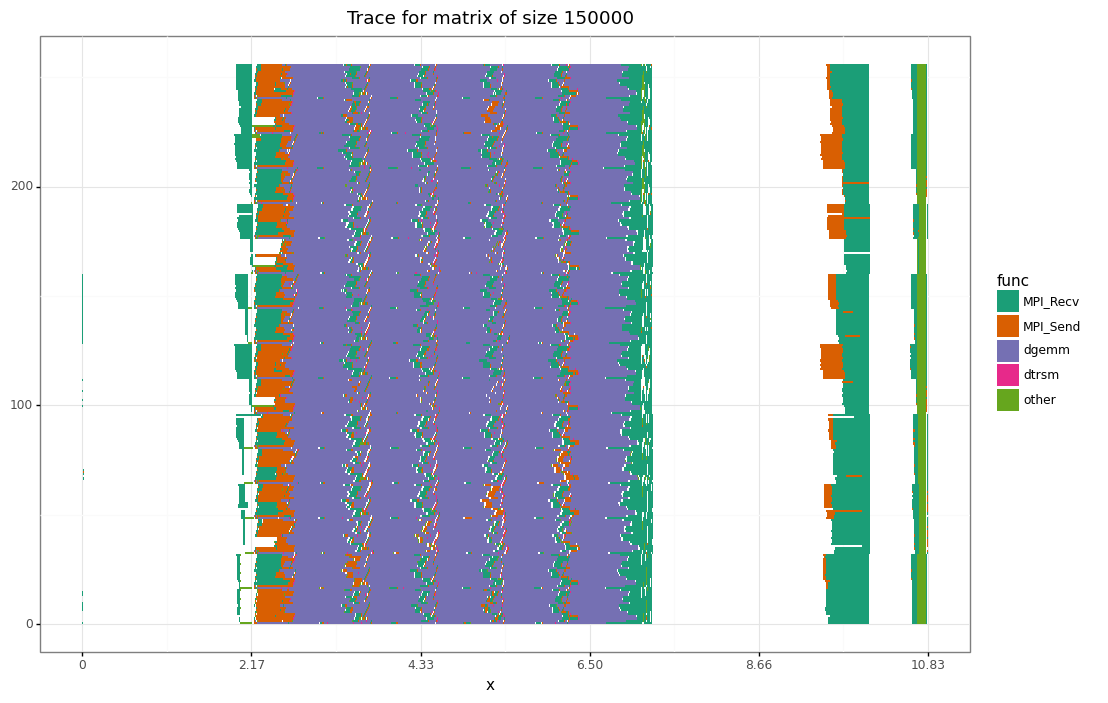

<ggplot: (-9223363253622437653)>


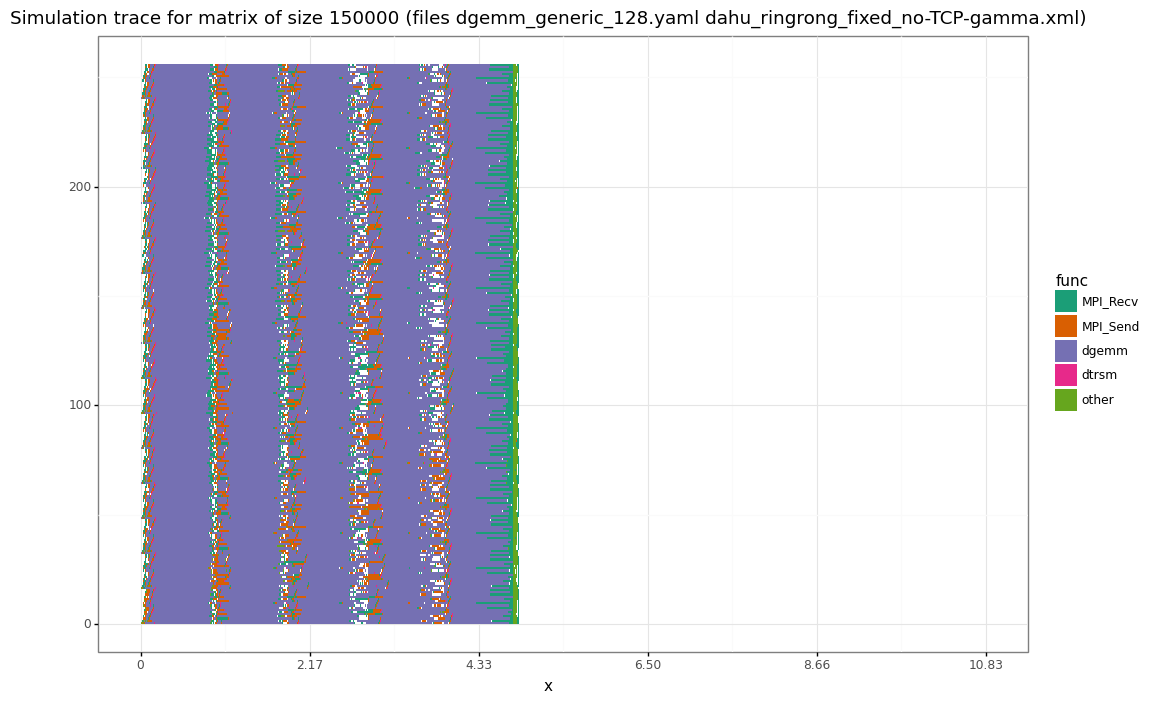

<ggplot: (8783089749238)>


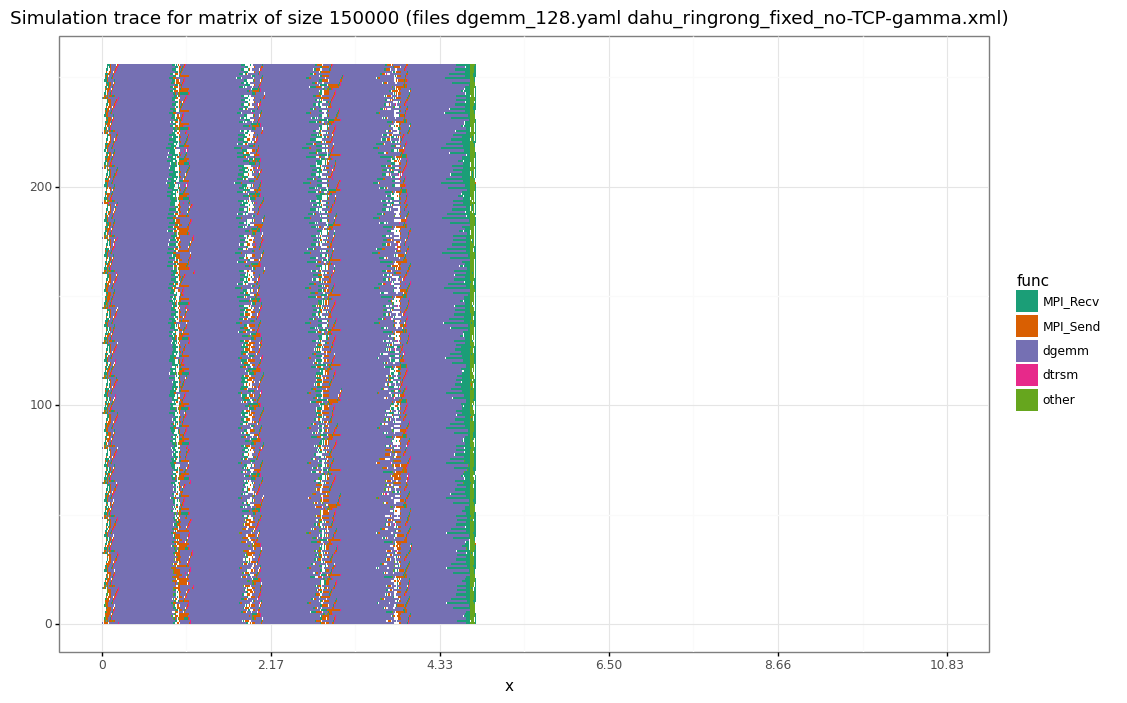

<ggplot: (8783182949885)>


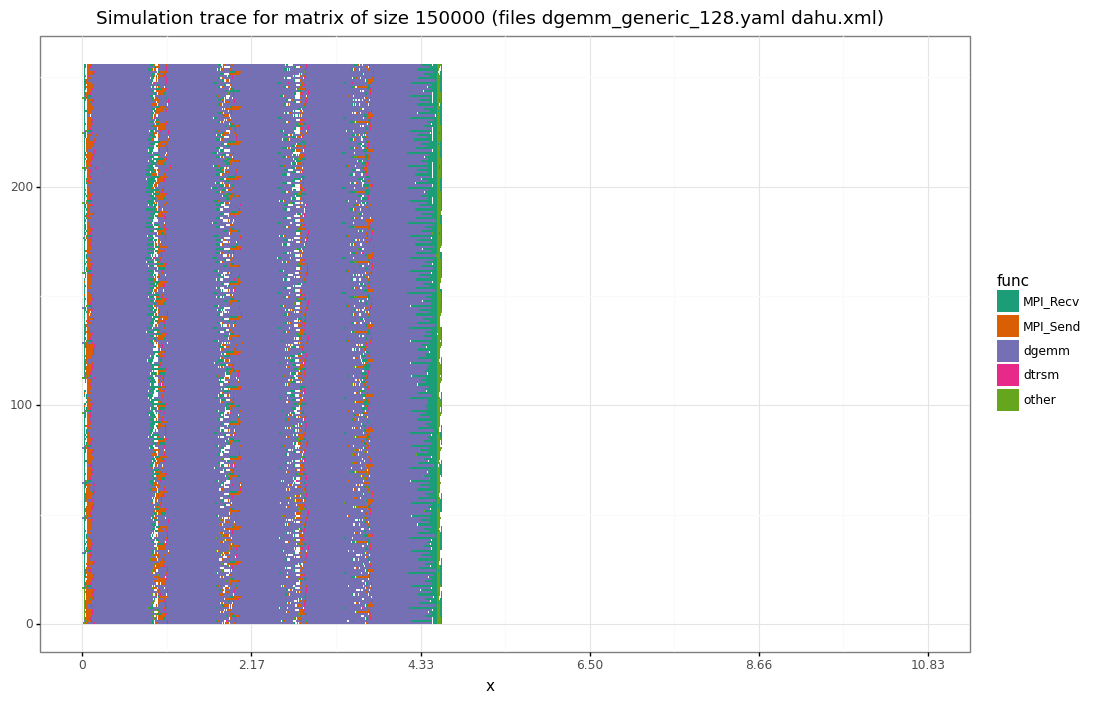

<ggplot: (8783183100936)>


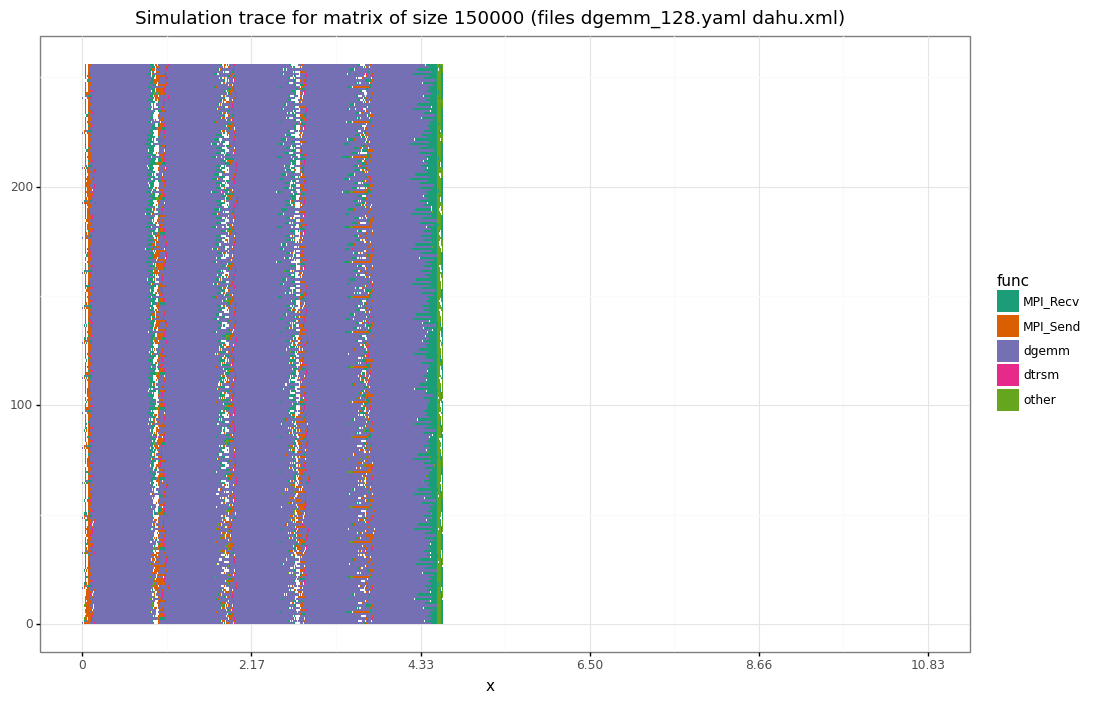

<ggplot: (-9223363253671590389)>


In [15]:
for size in sorted(non_null_traces.matrix_size.unique()):
    tmp = non_null_traces[(non_null_traces['matrix_size'] == size)]
    special_functions = {'HPL_bcast', 'HPL_pdgesv', 'HPL_pdupdateTT', 'HPL_pdges'}
    for func in special_functions:
        tmp = tmp[~tmp['function'].str.startswith(func)]
    lines = my_range(non_null_traces.start.min(), non_null_traces.start.max(), 4)
    print(plot(tmp[tmp['mode'] == 'reality'], lines=lines) + ggtitle('Trace for matrix of size %d' % size))
    for _, (dgemm_model, network_model) in tmp[tmp['mode'] != 'reality'][['dgemm_model', 'network_model']].drop_duplicates().iterrows():
        tmp_sim = tmp[(tmp['dgemm_model'] == dgemm_model) & (tmp['network_model'] == network_model) & (tmp['mode'] != 'reality')]
        print(plot(tmp_sim, lines=lines) + ggtitle('Simulation trace for matrix of size %d (files %s %s)' % (size, dgemm_model, network_model)))

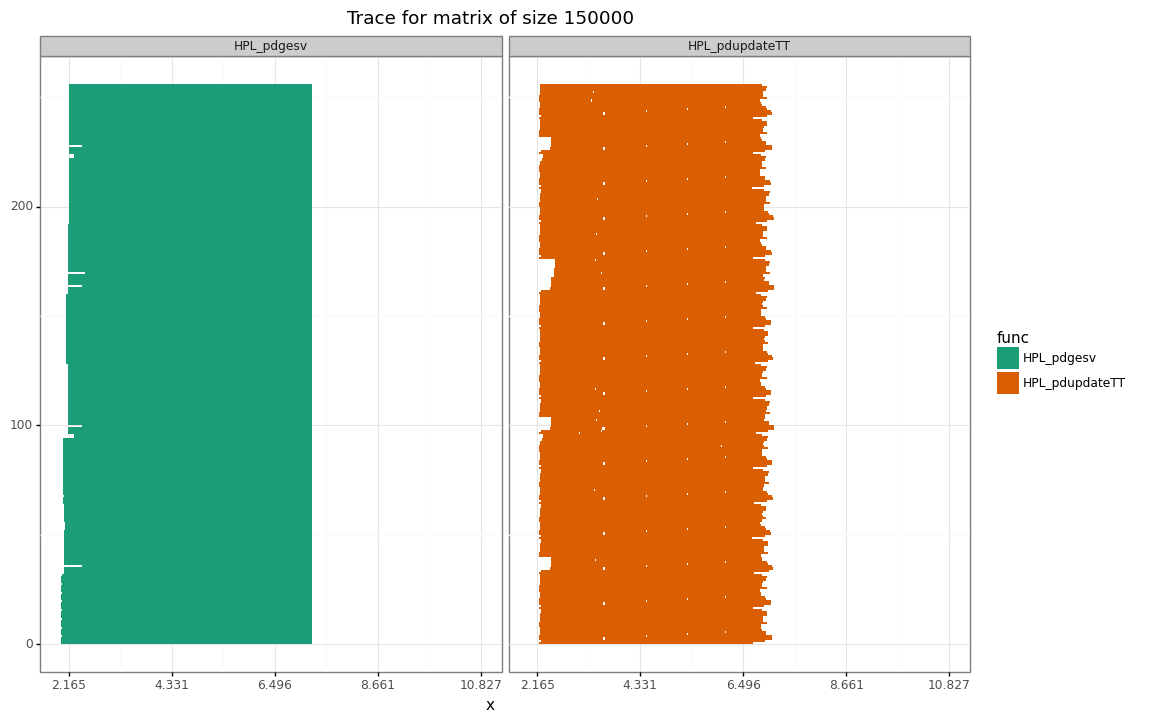

<ggplot: (8783182946557)>


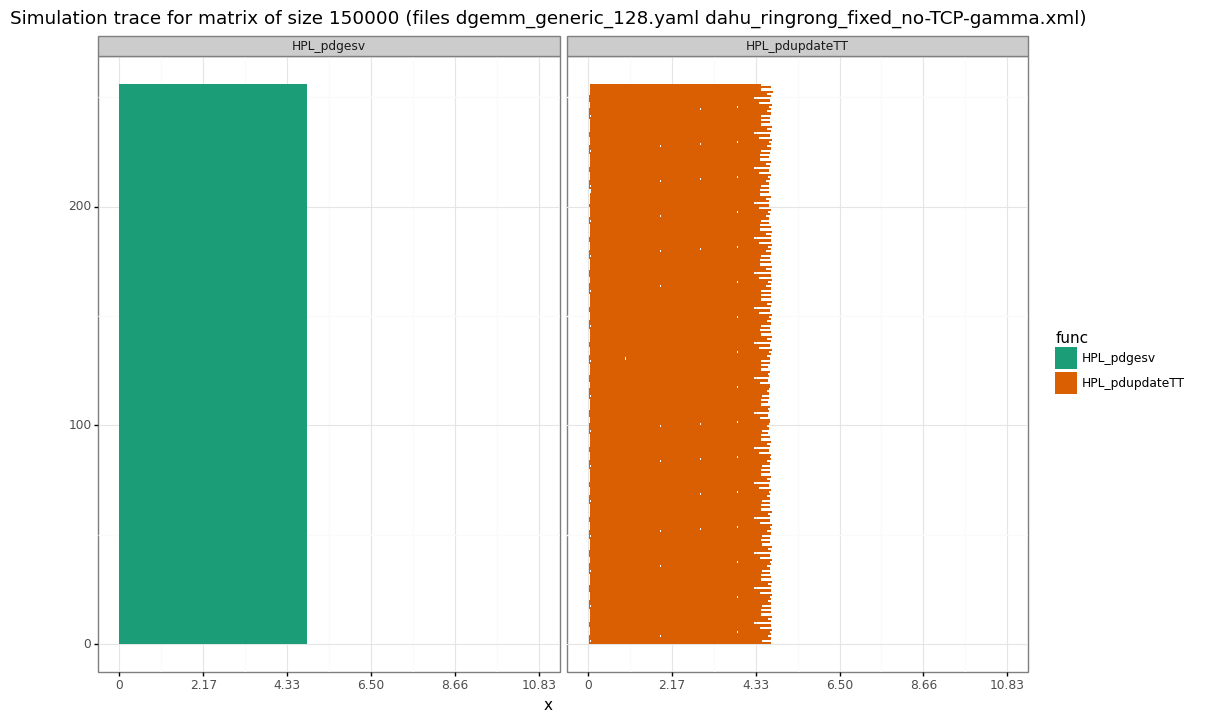

<ggplot: (8783040613366)>


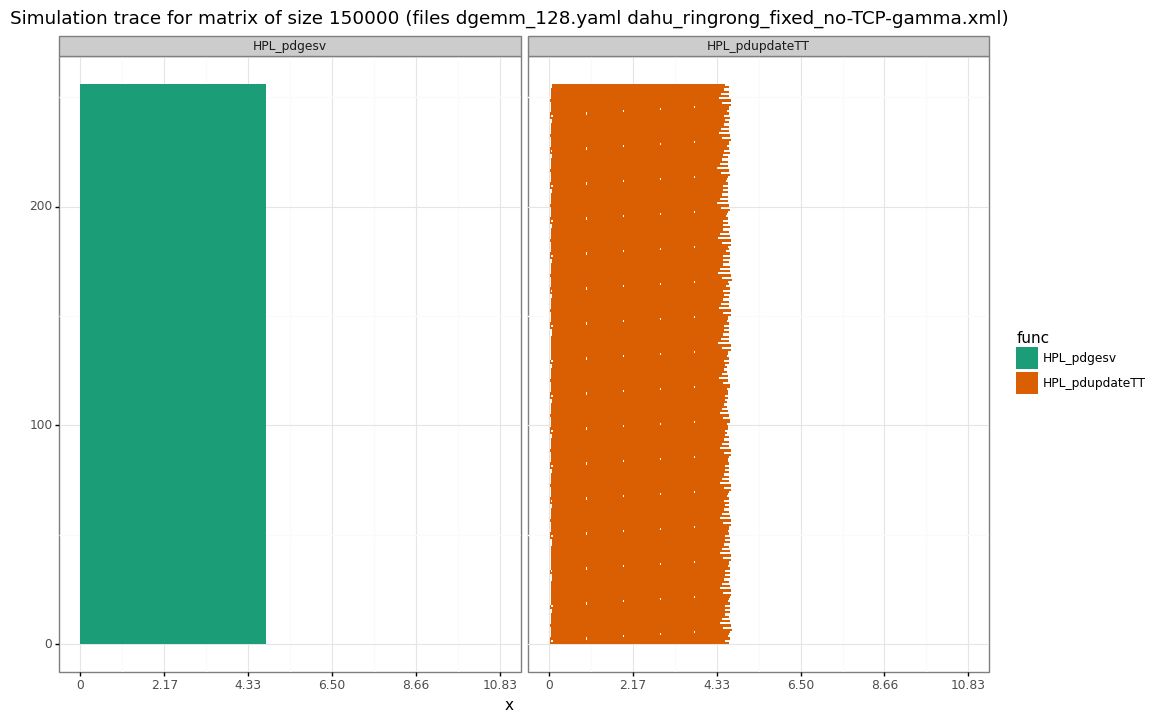

<ggplot: (8783183180783)>


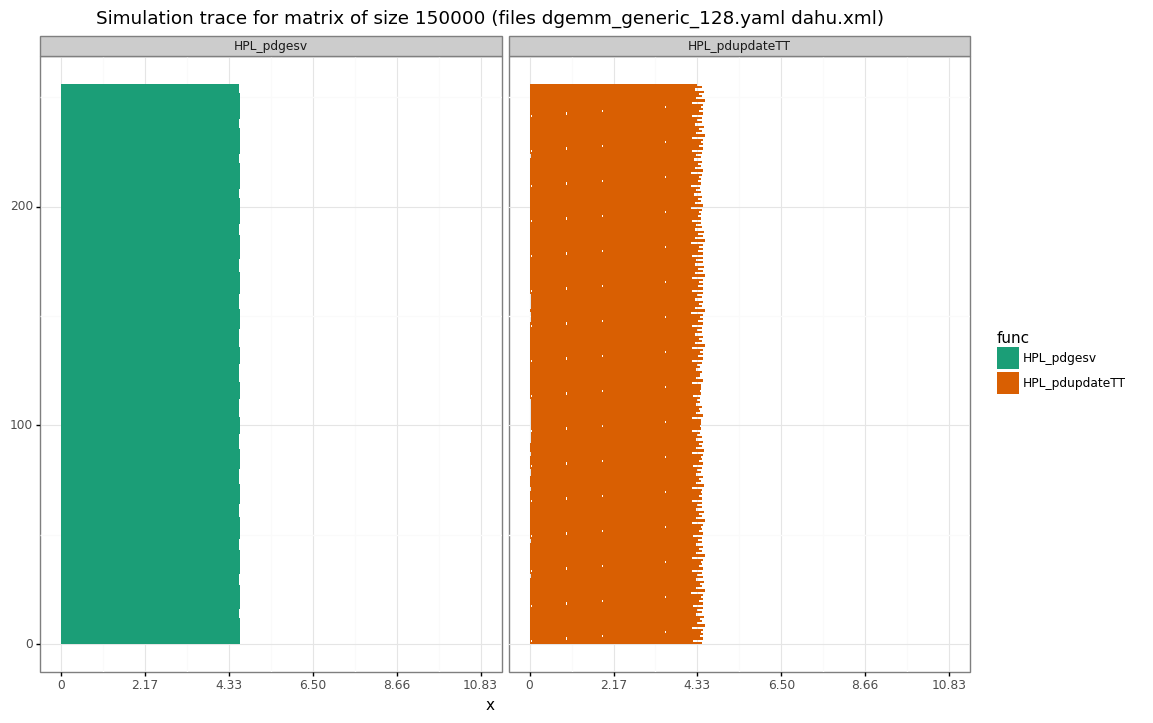

<ggplot: (-9223363253767690005)>


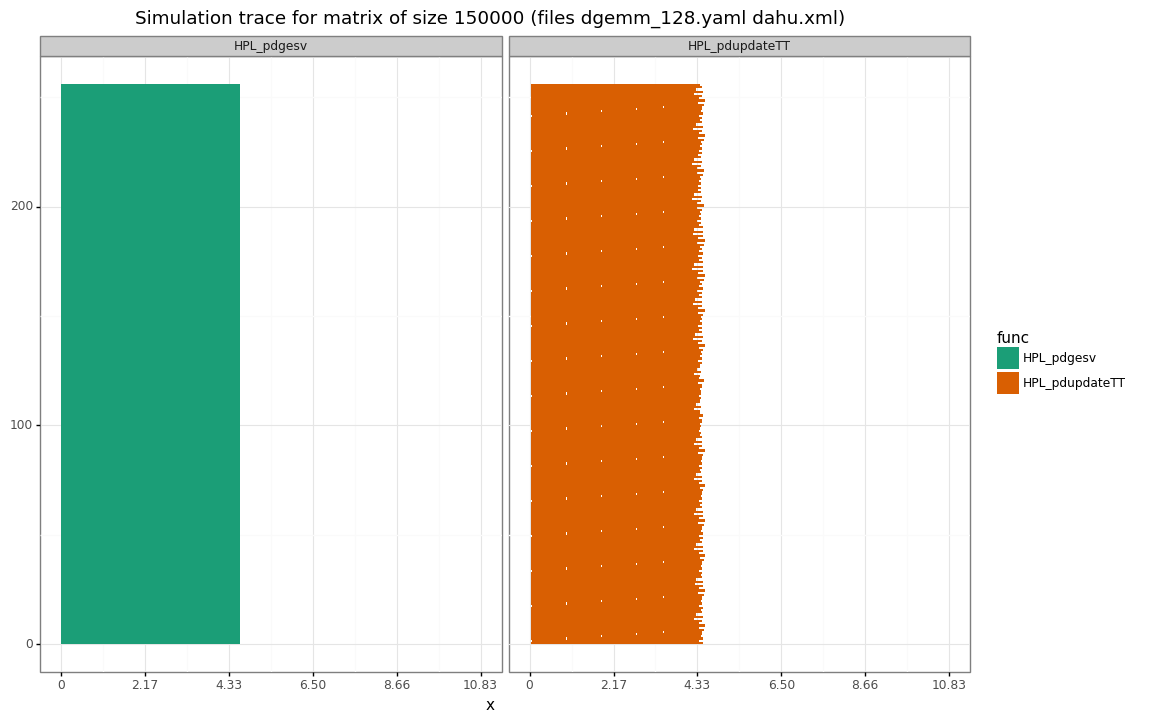

<ggplot: (-9223363253768761456)>


In [16]:
for size in sorted(non_null_traces.matrix_size.unique()):
    tmp = non_null_traces[(non_null_traces['matrix_size'] == size)]
    special_functions = {'HPL_pdgesv', 'HPL_pdupdateTT'}
    tmp = tmp[tmp['function'].isin(special_functions)].copy()
    tmp['func'] = tmp['function']
    lines = my_range(non_null_traces.start.min(), non_null_traces.start.max(), 4)
    print(plot(tmp[tmp['mode'] == 'reality'], lines=lines) + ggtitle('Trace for matrix of size %d' % size) + facet_wrap('func'))
    for _, (dgemm_model, network_model) in tmp[tmp['mode'] != 'reality'][['dgemm_model', 'network_model']].drop_duplicates().iterrows():
        tmp_sim = tmp[(tmp['dgemm_model'] == dgemm_model) & (tmp['network_model'] == network_model) & (tmp['mode'] != 'reality')]
        print(plot(tmp_sim, lines=lines) + ggtitle('Simulation trace for matrix of size %d (files %s %s)' % (size, dgemm_model, network_model)) + facet_wrap('func'))

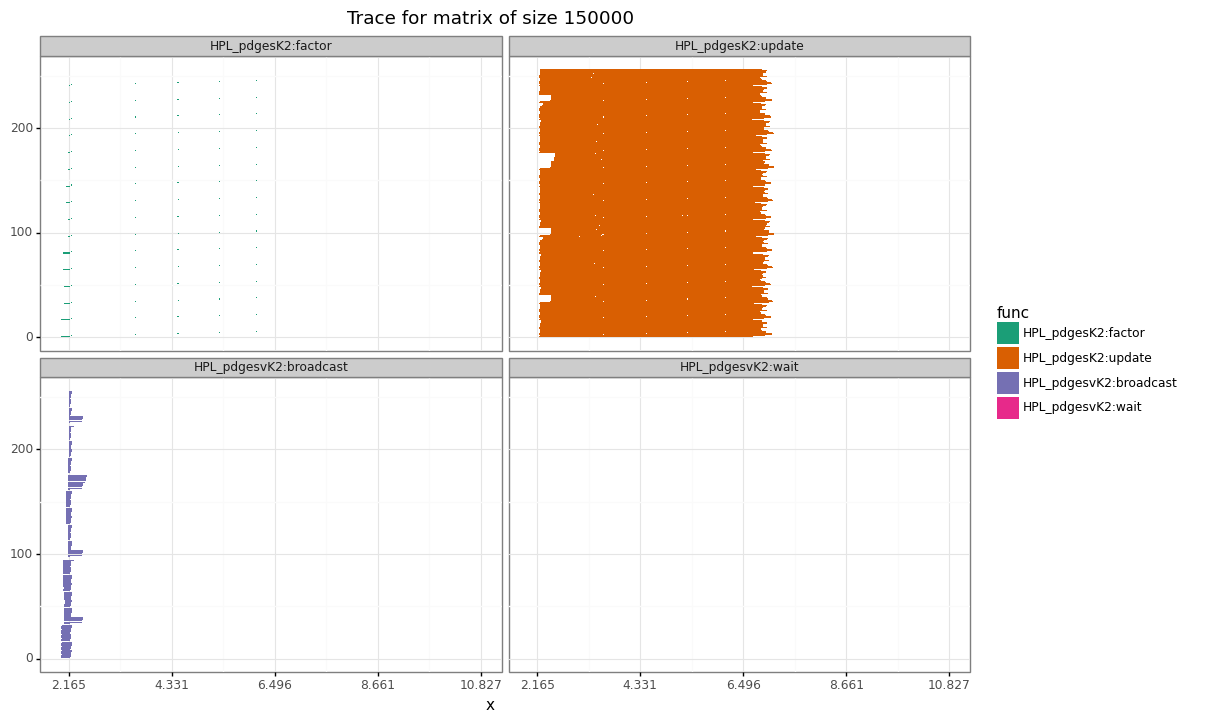

<ggplot: (8783227539197)>


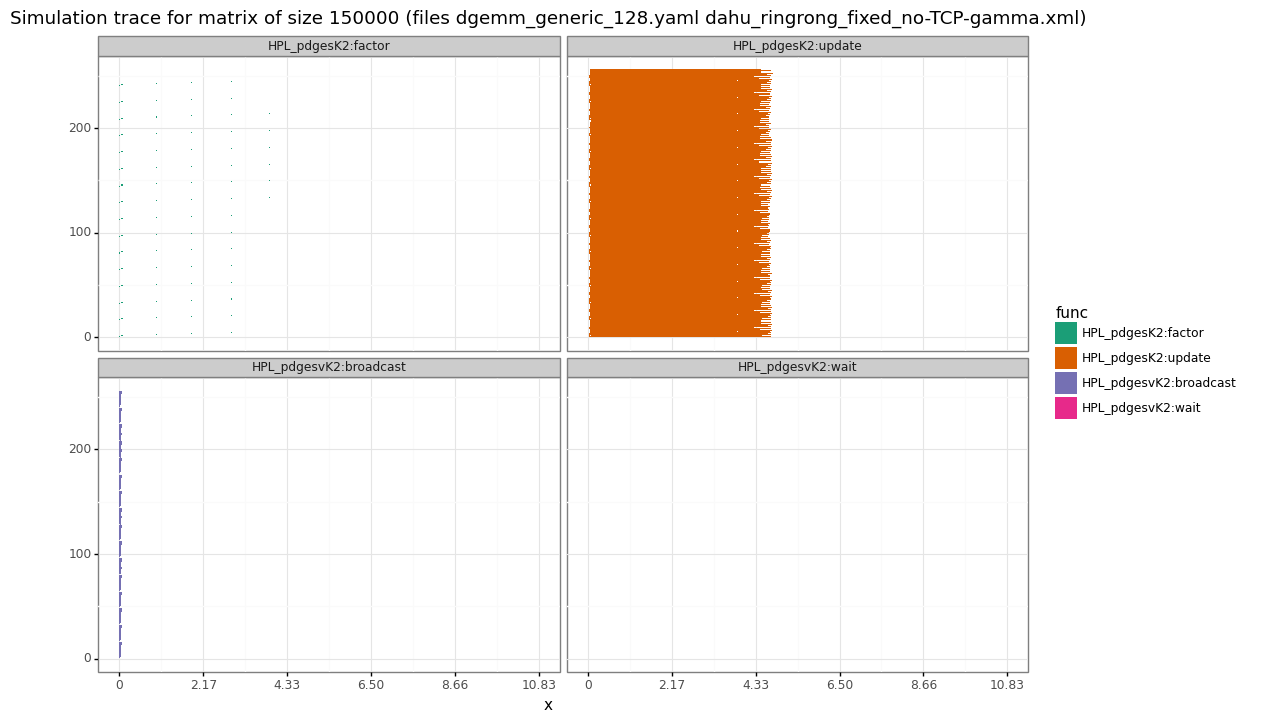

<ggplot: (8783227363343)>


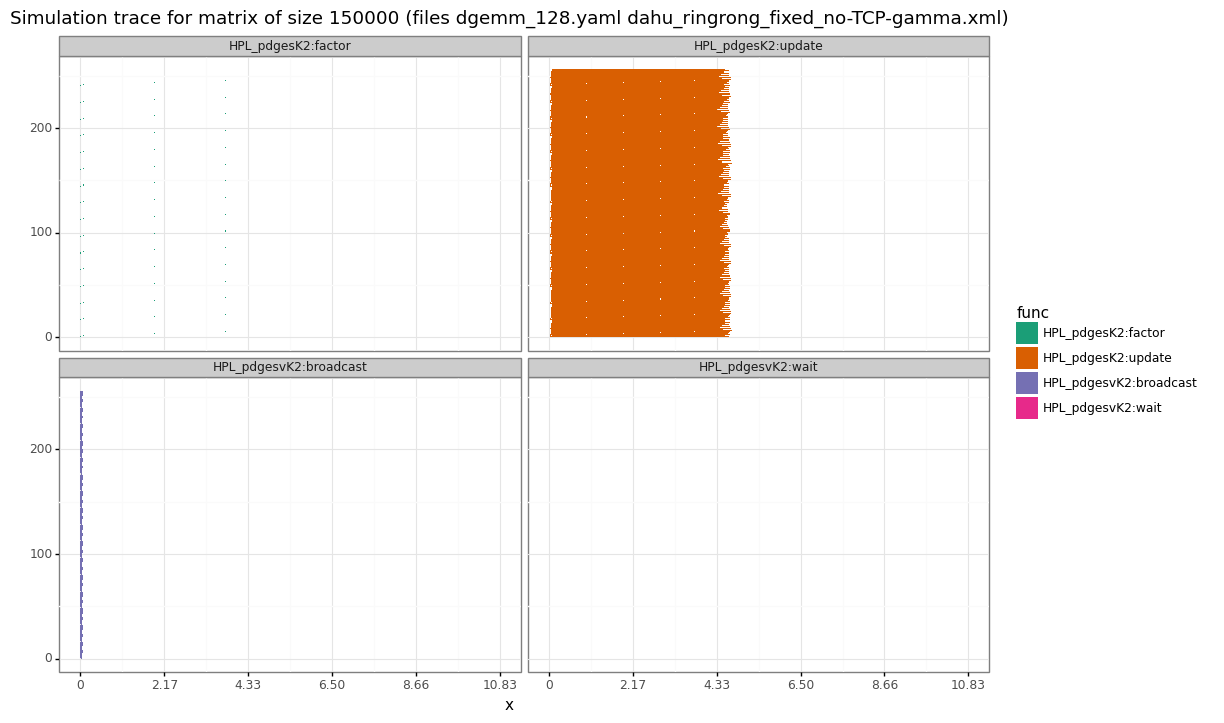

<ggplot: (-9223363253627813081)>


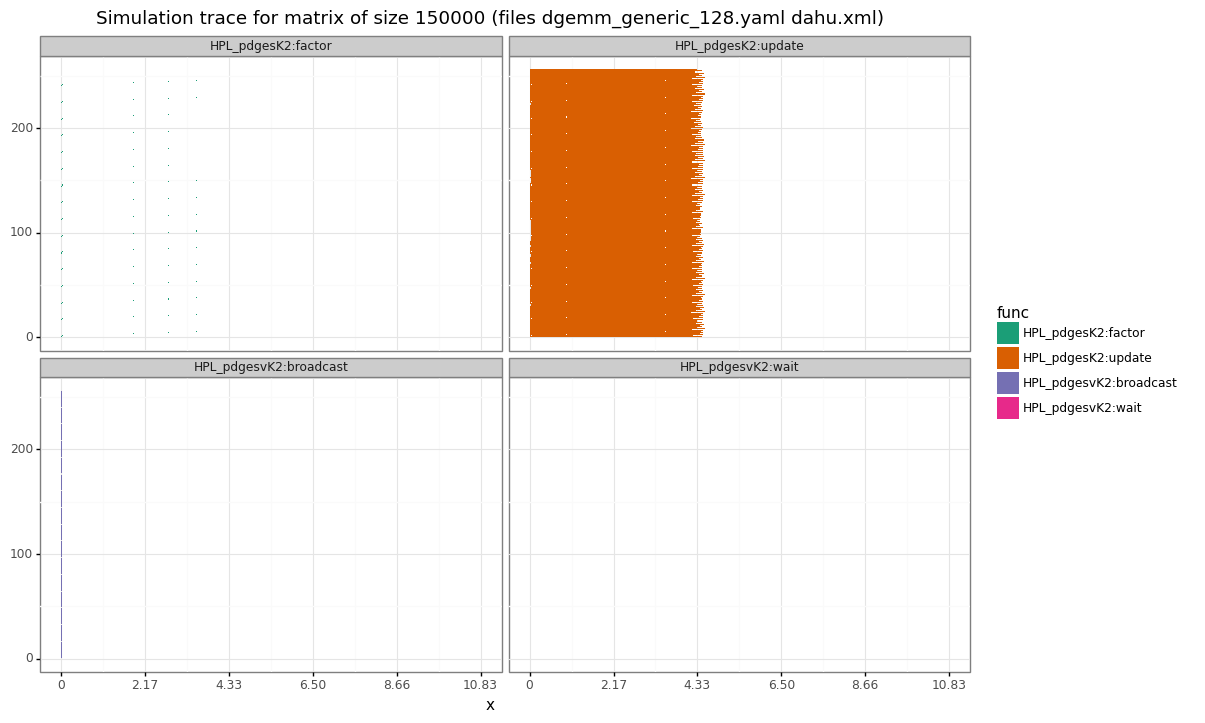

<ggplot: (8783227149523)>


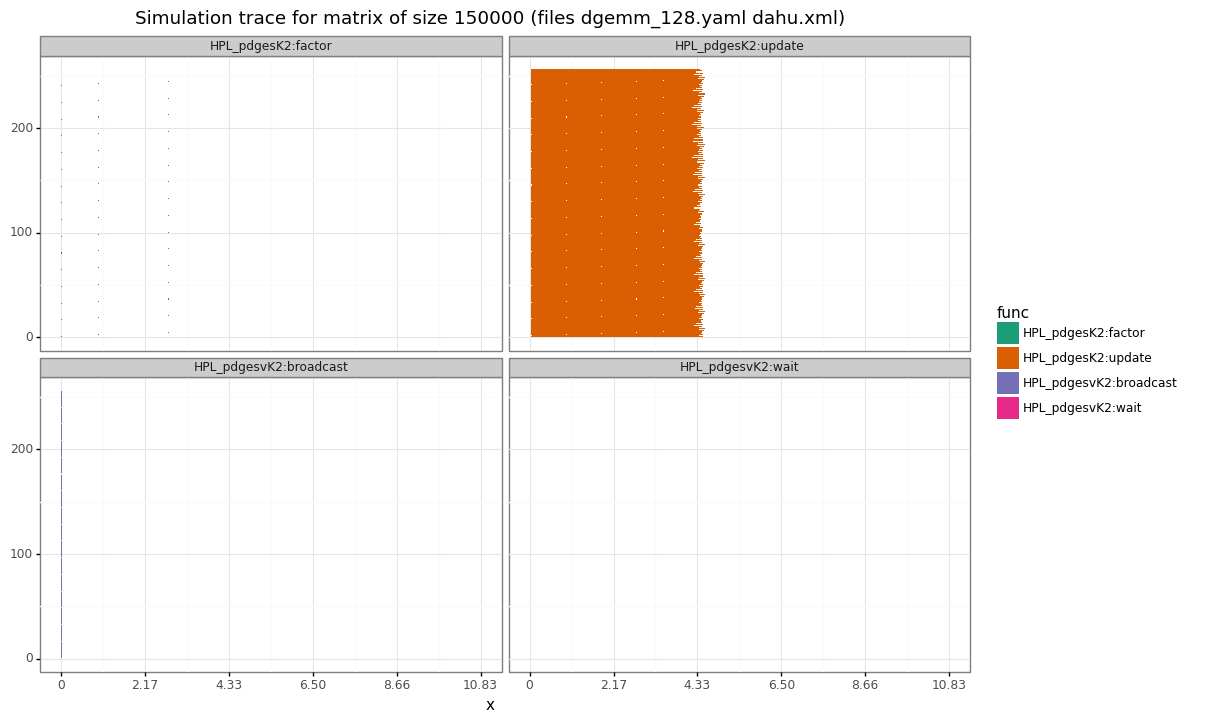

<ggplot: (-9223363253628026336)>


In [17]:
for size in sorted(non_null_traces.matrix_size.unique()):
    tmp = non_null_traces[(non_null_traces['matrix_size'] == size)]
    tmp = tmp[tmp['function'].str.contains('K2')]
    tmp['func'] = tmp['function']
    lines = my_range(non_null_traces.start.min(), non_null_traces.start.max(), 4)
    print(plot(tmp[tmp['mode'] == 'reality'], lines=lines) + ggtitle('Trace for matrix of size %d' % size) + facet_wrap('func'))
    for _, (dgemm_model, network_model) in tmp[tmp['mode'] != 'reality'][['dgemm_model', 'network_model']].drop_duplicates().iterrows():
        tmp_sim = tmp[(tmp['dgemm_model'] == dgemm_model) & (tmp['network_model'] == network_model) & (tmp['mode'] != 'reality')]
        print(plot(tmp_sim, lines=lines) + ggtitle('Simulation trace for matrix of size %d (files %s %s)' % (size, dgemm_model, network_model)) + facet_wrap('func'))

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


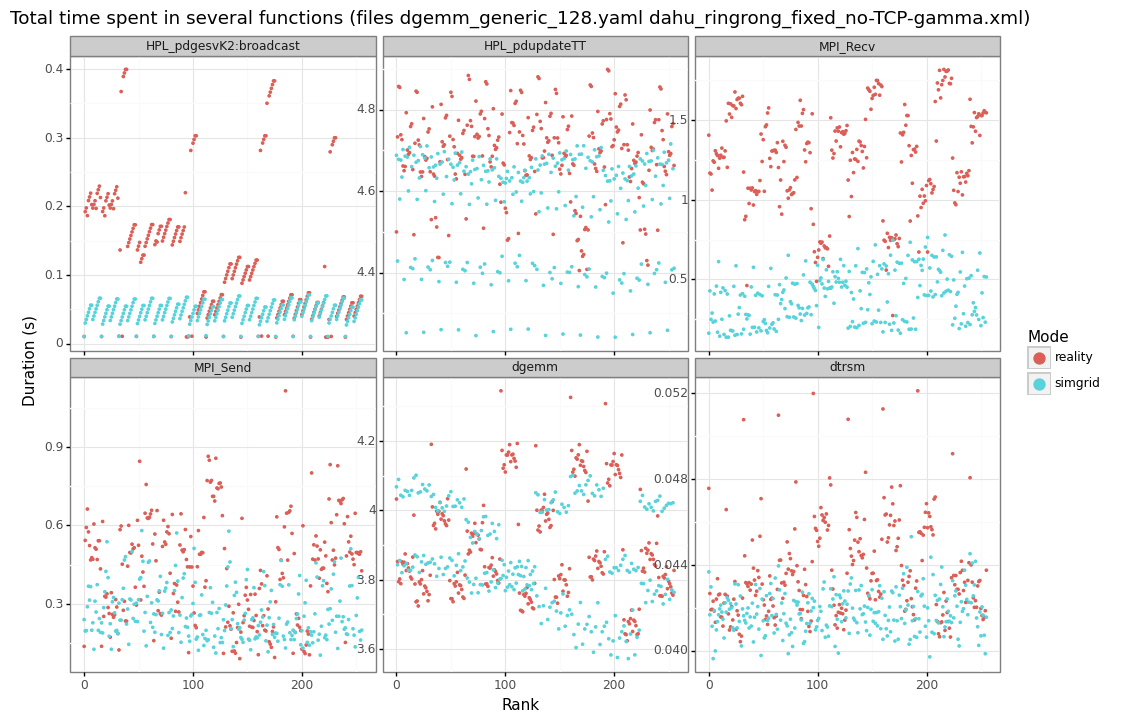

<ggplot: (-9223363253671477139)>


/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


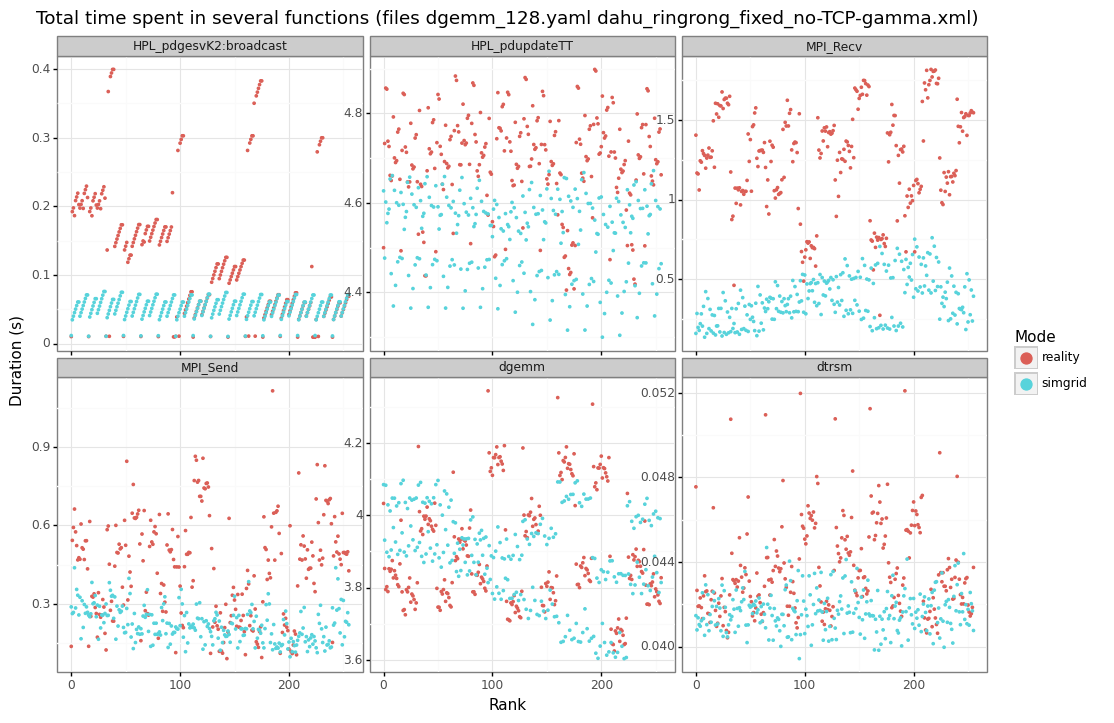

<ggplot: (8783183015018)>


/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


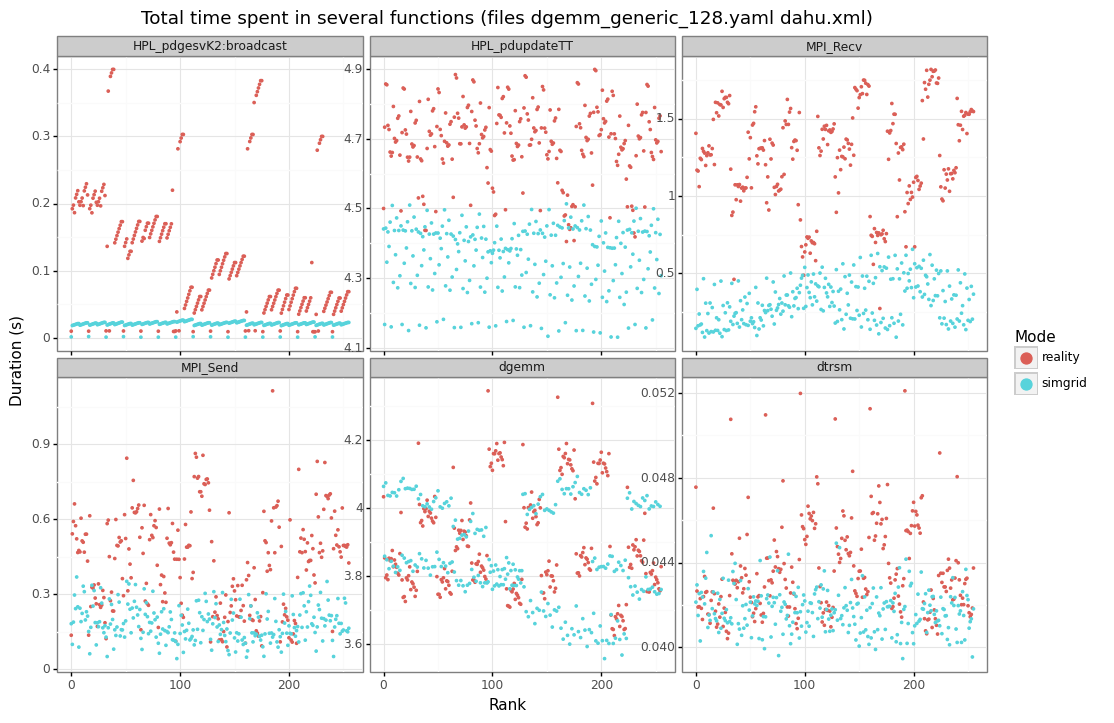

<ggplot: (8783227442033)>


/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


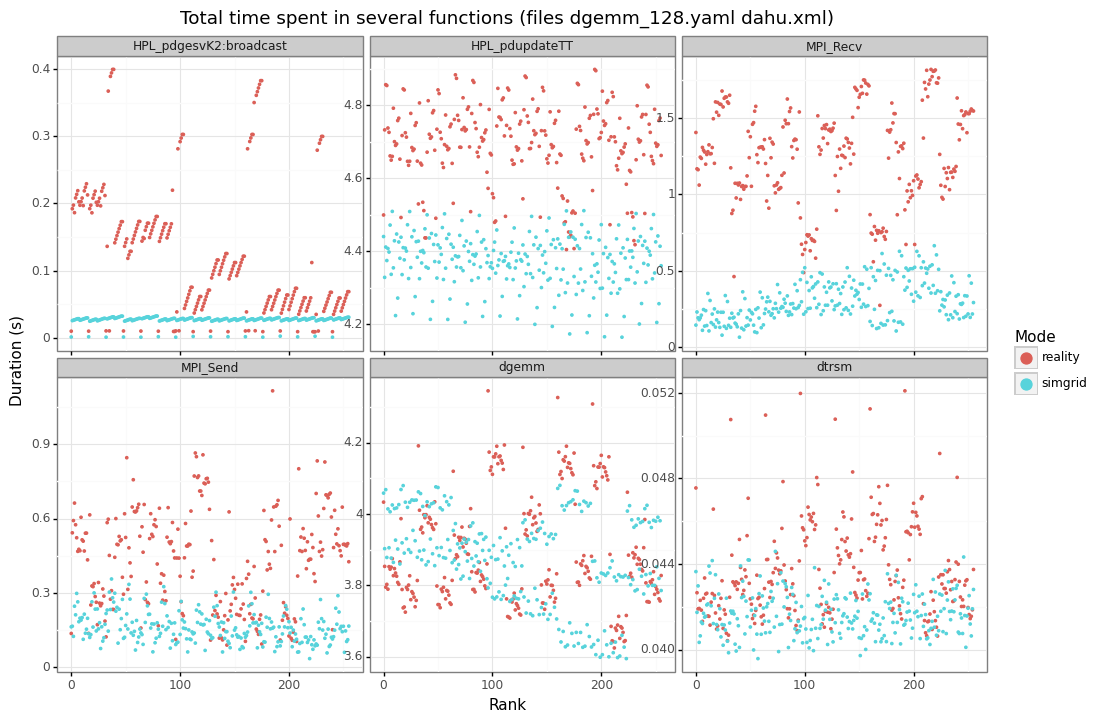

<ggplot: (-9223363253698460188)>


In [18]:
traces['dgemm_model'] = traces['dgemm_model'].astype(str)
traces['network_model'] = traces['network_model'].astype(str)
grouped = traces[traces['function'].isin({'HPL_pdupdateTT', 'HPL_pdgesvK2:broadcast', 'MPI_Send', 'MPI_Recv', 'dgemm', 'dtrsm'})].groupby(['function', 'mode', 'rank', 'dgemm_model', 'network_model'])[['duration']].sum().reset_index()
for _, (dgemm_model, network_model) in traces[traces['mode'] != 'reality'][['dgemm_model', 'network_model']].drop_duplicates().iterrows():
    tmp = grouped[((grouped['dgemm_model'] == dgemm_model) & (grouped['network_model'] == network_model) & (grouped['mode'] != 'reality')) | (grouped['mode'] == 'reality')]
    print(ggplot(tmp)
        + aes(x='rank', y='duration', color='mode')
        + geom_point(size=0.5)
        + theme_bw()
        + labs(x='Rank', y='Duration (s)', color='Mode')
        + ggtitle('Total time spent in several functions (files %s %s)' % (dgemm_model, network_model))
        + facet_wrap('function', scales='free')
        + guides(color=guide_legend(override_aes={'size': 4}))
    )